# Calibration
The purpose of this notebook is to calibrate our data based on peaks, following Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/electron-equivalent_energy_calibration).

In [39]:
#Imports
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import lmfit as lf              #Fitting
import matplotlib.pyplot as plt #Basic plotting library
sys.path.append('../')
from R76Tools import *          #Tools written by me for, e.x., importing our files

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
neogpath = "/data/chocula/neog/rq/"
baselinecorrections = pd.read_csv("../baselinecorrectionvalues.csv")
gaus_mod = lf.Model(gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=300)
gaus_params.add('sigma',min=0,value=3,max=200)
gaus_params.add('mu',min=100,max=300,value=150)
cal_mod = lf.Model(E_cal)
cal_params = cal_mod.make_params(a=300,c=13)

,series,m,b
0,07220420_0842,-0.093000,383.000000
1,07220421_1010,-0.087000,357.000000
2,07220422_1250,-0.089000,384.000000
3,07220425_0722,-0.100000,420.000000
4,07220425_1144,-0.110000,460.000000
...,...,...,...
90,07221124_1408,-0.030667,106.933333
91,07221124_1603,-0.030667,106.933333
92,07221124_1748,-0.030667,106.933333
93,07221124_2022,-0.030667,106.933333


In [11]:
#User-set Variables
ser = ["07220420_0842","07220421_1010","07220422_1250","07220425_0722","07220425_1144","07220425_1621"]
paths=[frittspath,frittspath,frittspath,frittspath,frittspath,frittspath]
#lab = ["0V","-4V","-21V","-65V","-84V","-84V"]

#Derived variables
_,z = makechain_list(ser,path=datapath,filters=[fittingfilters,"PTOFamps0"],aliases=calibrationaliases)

In [55]:
# Fix up the names
baselinecorrections = baselinecorrections.rename(columns={' m': 'm'})
baselinecorrections = baselinecorrections.rename(columns={' b': 'b'})
for i,x in enumerate(z):
    for j in range(len(baselinecorrections)): # Pull m and b values from the csv
        if baselinecorrections.series[j]==ser[i]:
            m=baselinecorrections.m[j]
            b=baselinecorrections.b[j]
    x["pt_keV_bscorr"] = x["pt_keV"]/(1+m*x["BSel"]/b)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1+m*x["BSel"]/b)

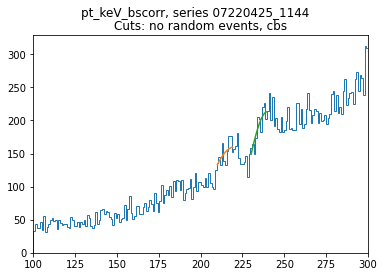

07220425_1144 a: 361 c: 9


In [82]:
#Initial plotting
i=3
lolim=100
hilim=300
fit1lo,fit1hi=210,220
fit2lo,fit2hi=230,240
bins = np.linspace(lolim,hilim,200)
h4ptdat = z[i]["pt_keV_bscorr"][~z[i]["crand"] & z[i]["cbs"]]
h4pt = plt.hist(h4ptdat,bins=bins,histtype="step")

#Lmfit setup
weights = 1/np.sqrt(h4pt[0]) #weights are 1/uncertainty which are Poisson so 1/sqrt(data)
bins = (h4pt[1][:-1] + h4pt[1][1:])/2 #restructure to align for calculations
#fit 1st region
region1 = (bins >= fit1lo) & (bins <= fit1hi)
highestregion1 = h4pt[0][region1]==max(h4pt[0][region1])
gaus_params.add('mu',min=fit1lo,max=fit1hi,value=bins[region1][highestregion1][0])
fit1 = gaus_mod.fit(h4pt[0][region1],gaus_params,x=bins[region1],weights=weights[region1])
#fit 2nd region
region2 = (bins >= fit2lo) & (bins <= fit2hi)
highestregion2 = h4pt[0][region2]==max(h4pt[0][region2])
gaus_params.add('mu',min=fit2lo,max=fit2hi,value=bins[region2][highestregion2][0])
fit2 = gaus_mod.fit(h4pt[0][region2],gaus_params,x=bins[region2],weights=weights[region2])

#Plot fits
plt.plot(bins[region1],fit1.best_fit)
plt.plot(bins[region2],fit2.best_fit)
plt.xlim(lolim,hilim)
plt.suptitle("pt_keV_bscorr, series "+ser[i])
plt.title("Cuts: no random events, cbs")
plt.show()
x = [fit1.best_values['mu'],fit2.best_values['mu']]
y = y_calib
c = y[0]*y[1]*(x[1]-x[0])/(x[0]*y[1]-x[1]*y[0])
a = x[0]*(c/y[0] + 1)
print(ser[i],"a:",round(a),"c:",round(c))

In [37]:
fit1

In [5]:
fit2

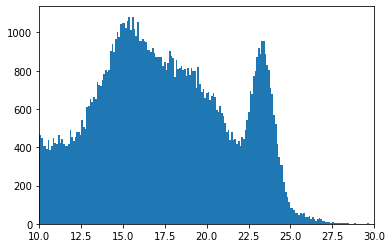

In [63]:
#Calculate our calibration
x = [fit1.best_values['mu'],fit2.best_values['mu']]
y = y_calib
c = y[0]*y[1]*(x[1]-x[0])/(x[0]*y[1]-x[1]*y[0])
a = x[0]*(c/y[0] + 1)
#Apply the result
z[4]["pt_keVee"] = c*z[4]["pt_keV_bscorr"]/(a-z[4]["pt_keV_bscorr"])
z[4]["pt0_keVee"] = c*z[4]["pt0_keV_bscorr"]/(a-z[4]["pt0_keV_bscorr"])
#And plot
h4keVee = plt.hist(z[4]["pt_keVee"][~z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(10,30,200))
plt.xlim(10,30,200)
plt.show()

Emperical: 36.98524687471198
Expected: 23.105263157894736


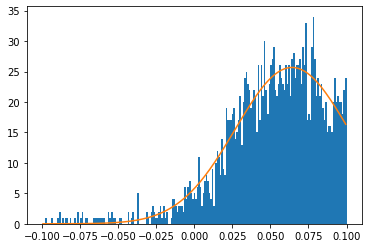

In [81]:
#Diagnostics
g_NTL_empirical = a/c     #Calculated gain from calibration
g_NTL_expected = 1+84/3.8 #1+HV/mean energy to produce one pair for Si
print("Emperical:",g_NTL_empirical)
print("Expected:",g_NTL_expected)

h4n = plt.hist(z[4]["pt0_keVee"][~z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(-0.1,0.1,200))
gaus_params.add('mu',value=0)
bins = (h4n[1][:-1]+h4n[1][1:])/2
fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
plt.plot(bins,fit_NTL.best_fit)
plt.show()
fit_NTL

In [8]:
print(a,c)

290.18280058972545 12.496987662025882


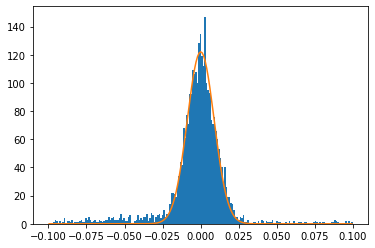

In [9]:
#Debug
z[4]["pt_keVee_root"] = 13.1849*z[4]["pt_keV_bscorr"]/(297.667-z[4]["pt_keV_bscorr"])
z[4]["pt0_keVee_root"] = 13.1849*z[4]["pt0_keV_bscorr"]/(297.667-z[4]["pt0_keV_bscorr"])

h4n = plt.hist(z[4]["pt0_keVee_root"][z[4]["crand"] & z[4]["cbs"]],bins=np.linspace(-0.1,0.1,200))
gaus_params.add('mu',value=0,min=-0.1,max=0.1)
bins = (h4n[1][:-1]+h4n[1][1:])/2
fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
plt.plot(bins,fit_NTL.best_fit)
plt.show()
fit_NTL